In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding,Flatten,Dropout, Dense, Concatenate, TimeDistributed, Bidirectional,Attention
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from statistics import mode
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import functools
from scipy.stats import norm
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA
import pypfopt
from scipy.stats import t
from pypfopt import expected_returns
from pypfopt import risk_models
from scipy.stats import genextreme
from scipy.stats import gaussian_kde

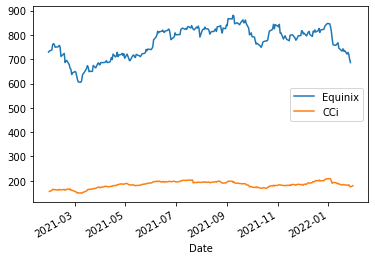

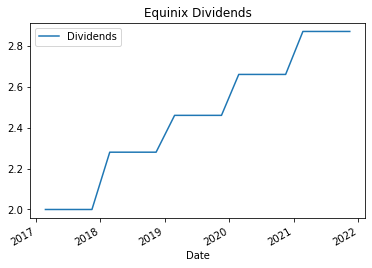

In [2]:
eqix_df=pd.read_csv('EQIX.csv',parse_dates=['Date'],index_col=0)
eqix_df=eqix_df.sort_index().tail(254)
cci_df = pd.read_csv('CCI.csv',parse_dates=['Date'],index_col=0)
cci_df=cci_df.sort_index().tail(254)
eqix_df['Open'].plot(label='Equinix')
cci_df['Open'].plot(label='CCi')
plt.legend()
plt.show()
eqix_dividend=pd.read_csv('EQIX_Dividend.csv',parse_dates=['Date'],index_col=0)
eqix_dividend.plot()
plt.title('Equinix Dividends')
plt.show()

C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_6500/1052066201.py:8: UserWarning: Legend does not support <AxesSubplot:xlabel='Date', ylabel='volatility'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=[line1])
C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_6500/1052066201.py:14: UserWarning: Legend does not support <AxesSubplot:xlabel='Date', ylabel='pct_change'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  twinx.legend(handles=[line2])


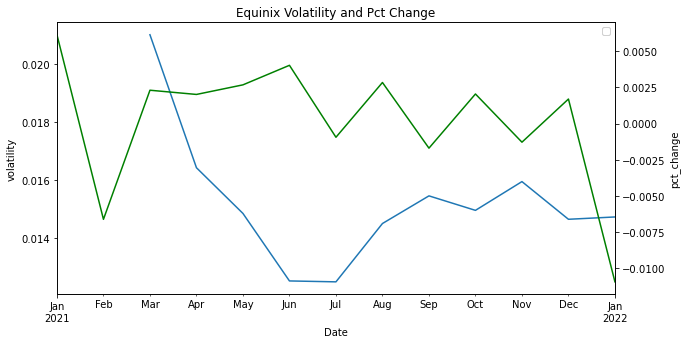

In [3]:
fig,ax=plt.subplots(figsize=(10,5))
eqix_returns=eqix_df.pct_change()
rolling=eqix_returns['Open'].rolling(30)
volatility = rolling.std().dropna()
vol_mean= volatility.resample("M").mean()
line1=vol_mean.plot(label="volatility",ax=ax)
ax.set_ylabel("volatility")
ax.legend(handles=[line1])
twinx=ax.twinx()
volility_chg=eqix_df.pct_change().resample("M").mean()

line2=volility_chg['Open'].plot(label="pct change",ax=twinx,c='g')
twinx.set_ylabel('pct_change')
twinx.legend(handles=[line2])
plt.title('Equinix Volatility and Pct Change')
plt.show()

C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_12784/3140623786.py:8: UserWarning: Legend does not support <AxesSubplot:xlabel='Date', ylabel='volatility'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=[line1])
C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_12784/3140623786.py:14: UserWarning: Legend does not support <AxesSubplot:xlabel='Date', ylabel='pct_change'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  twinx.legend(handles=[line2])


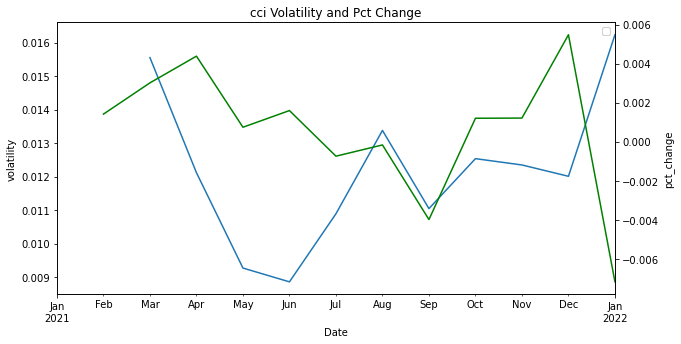

In [33]:
fig,ax=plt.subplots(figsize=(10,5))
cci_returns=cci_df.pct_change()
rolling=cci_returns['Open'].rolling(30)
volatility = rolling.std().dropna()
vol_mean= volatility.resample("M").mean()
line1=vol_mean.plot(label="volatility",ax=ax)
ax.set_ylabel("volatility")
ax.legend(handles=[line1])
twinx=ax.twinx()
volility_chg=cci_df.pct_change().resample("M").mean()

line2=volility_chg['Open'].plot(label="pct change",ax=twinx,c='g')
twinx.set_ylabel('pct_change')
twinx.legend(handles=[line2])
plt.title('cci Volatility and Pct Change')
plt.show()

VaR_95:  0.023104117456808126 ; Backtest:  1.0


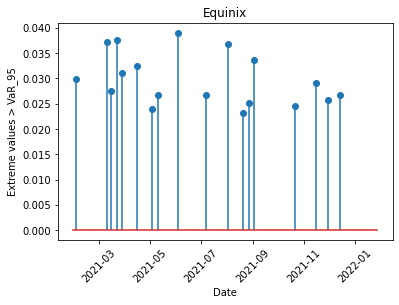

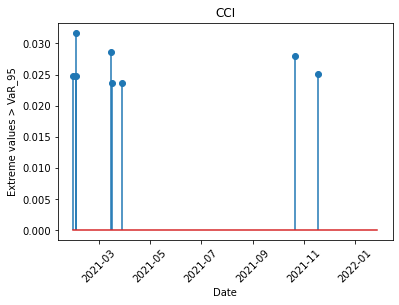

95% confidence the maximum daily loss will be 203540.2294256147 initial investment 10000000


In [4]:
#https://www.interviewqs.com/blog/value-at-risk
initial_investment=10000000

weights = np.array([.50, .5])

eqix_df['Pct_Change'] =eqix_df['Open'].pct_change()
cci_df['Pct_Change']=cci_df['Open'].pct_change()

dfs=[eqix_df['Pct_Change'],cci_df['Pct_Change']]
returns = functools.reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
returns=returns.rename(columns={"Pct_Change_x":"eqix","Pct_Change_y":"cci"}).bfill()

#print(returns)

cov_matrix = returns.cov()
mean_returns = returns.mean()

portfolio_mean = mean_returns.dot(weights)
 
# Calculate portfolio standard deviation
portfolio_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
 
# Calculate mean of investment
mean_investment = (1+portfolio_mean) * initial_investment
             
# Calculate standard deviation of investmnet
stdev_investment = initial_investment * portfolio_stdev

#cov_matrix=returns.cov()
#avg_returns=returns.mean()

VaR_95 = np.quantile(returns, 0.95)

extreme_values = returns[returns > VaR_95]
print("VaR_95: ", VaR_95, "; Backtest: ", len(extreme_values) / len(returns) )

plt.stem(extreme_values.index, extreme_values['eqix'].values)
plt.ylabel("Extreme values > VaR_95"); plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title('Equinix')
plt.show()

plt.stem(extreme_values.index, extreme_values['cci'].values)
plt.ylabel("Extreme values > VaR_95"); plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title('CCI')
plt.show()

conf_level1 = 0.05
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

var_1d1 = initial_investment - cutoff1

print("95% confidence the maximum daily loss will be", var_1d1, "initial investment",initial_investment)


Percentage to be held in the portfolio in the period OrderedDict([('eqix', 0.4999999999999999), ('cci', 0.4999999999999999)])


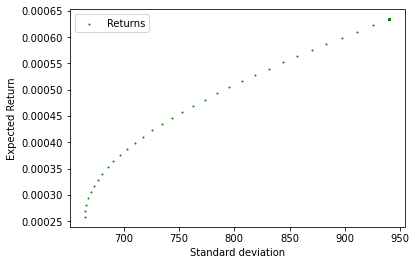

In [5]:
cs = CovarianceShrinkage(returns)
e_cov = cs.ledoit_wolf()
ef=pypfopt.efficient_frontier.EfficientFrontier(None, e_cov)
min_vol_weights=ef.min_volatility()
print("Percentage to be held in the portfolio in the period", min_vol_weights)

cla=CLA(mean_returns,e_cov)

(ret, vol, weights) = cla.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'Returns')
plt.xlabel('Standard deviation')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

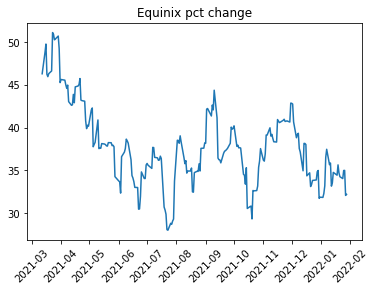

0.05049533117978571
CVaR is the expected value of loss given a minimum loss threshold.


In [6]:
mu = returns['eqix'].rolling(30).mean()
sigma = returns['eqix'].rolling(30).std()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) 
                    for params in rolling_parameters ] )

plt.plot(returns.index, 0.01 * VaR_99 * 100000)
plt.xticks(rotation=45)
plt.title('Equinix pct change')
plt.show()

p = t.fit(returns['eqix'])
VaR_99 = t.ppf(0.99, *p)
# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)
print("CVaR is the expected value of loss given a minimum loss threshold.")

In [7]:
#https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9
dfs=[eqix_df['Open'],cci_df['Open']]
prices = functools.reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
prices=prices.rename(columns={"Open_x":"eqix","Open_y":"cci"}).ffill()


mu = expected_returns.mean_historical_return(prices)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(prices)
ef = pypfopt.efficient_frontier.EfficientFrontier(mu, Sigma, weight_bounds=(-1,1))
sharpe_pfolio=ef.max_sharpe()
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

print("100% holding of cci")

OrderedDict([('eqix', 0.0), ('cci', 1.0)])
100% holding of cci


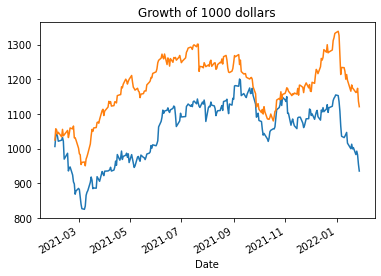

In [9]:
investment=1000
prices['eqix_accum']=prices['eqix'].pct_change()
prices['cci_accum']=prices['cci'].pct_change()
prices['eqix_accum'] = prices['eqix_accum'].add(1)
prices['cci_accum'] = prices['cci_accum'].add(1)
prices['eqix_accum'] = prices['eqix_accum'].cumprod()
prices['cci_accum'] = prices['cci_accum'].cumprod()
prices['eqix_accum'] = prices['eqix_accum'].mul(investment)
prices['cci_accum'] = prices['cci_accum'].mul(investment)

prices['eqix_accum'].plot()  
prices['cci_accum'].plot()

plt.title('Growth of 1000 dollars')
plt.show()

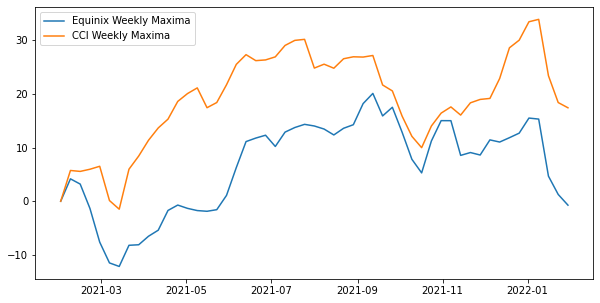

<Figure size 432x288 with 0 Axes>

733.469971 33.48785016436868
finds maximum loss over one week period at 99% confidence


In [14]:
original_price=prices.iloc[0]['cci']
prices['cci_net']=(prices['cci'].astype(float)-original_price)/original_price*100
original_price=prices.iloc[0]['eqix']
prices['eqix_net']=(prices['eqix'].astype(float)-original_price)/original_price*100

eqix_weekly_maxima = prices['eqix_net'].resample("W").max()
cci_weekly_maxima = prices['cci_net'].resample("W").max()

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(eqix_weekly_maxima, label = "Equinix Weekly Maxima")
ax.plot(cci_weekly_maxima, label = "CCI Weekly Maxima")
ax.legend()
plt.figure("weekly")
plt.show()

params = genextreme.fit(weekly_maxima)

VaR99 = genextreme.ppf(0.99,*params)

print(original_price,VaR99)
print("finds maximum loss over one week period at 99% confidence")

#CVaR_99 = (1/ (1-0.99)) * genextreme.expect(lambda x: x, *params,lb=VaR_99)
#print(CVaR_99)

In [3]:
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

COLUMNS=['Open']
dataset=eqix_df[COLUMNS]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

look_back=10
trainX=[]
testX=[]
y_train=[]

trainX, y_train = create_dataset(train, look_back)
testX, y_test = create_dataset(test, look_back)

X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [23]:
latent_dim=1000
n_future=1

model = Sequential()

model.add(Bidirectional(LSTM(units=latent_dim, return_sequences=True, 
                             input_shape=(X_train.shape[1], 1))))
#LSTM 1
model.add(Bidirectional(LSTM(latent_dim,return_sequences=True,dropout=0.4,recurrent_dropout=0.4,name='lstm1'))) 
#model.add(LSTM(latent_dim,return_sequences=True,dropout=0.4,recurrent_dropout=0.4,name='lstm1')) 

#LSTM 2 
model.add(Bidirectional(LSTM(latent_dim,return_sequences=True,dropout=0.2,recurrent_dropout=0.4,name='lstm2')))
#model.add(LSTM(latent_dim,return_sequences=True,dropout=0.2,recurrent_dropout=0.4,name='lstm2'))

#LSTM 3 
model.add(Bidirectional(LSTM(latent_dim, return_sequences=False,dropout=0.2,recurrent_dropout=0.4,name='lstm3')))
#model.add(LSTM(latent_dim, return_sequences=False,dropout=0.2,recurrent_dropout=0.4,name='lstm3'))

model.add(Dense(units = n_future))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])

#input_shape=(X_train.shape[1], 1)
#model.build(input_shape)
#model.summary()

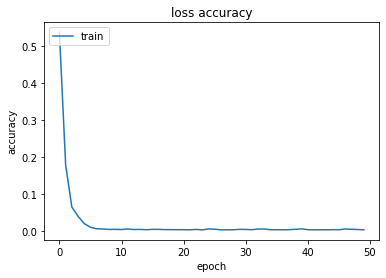

In [24]:
history=model.fit(X_train, y_train,epochs=50,verbose=0)

plt.plot(history.history['loss'])
plt.title('loss accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

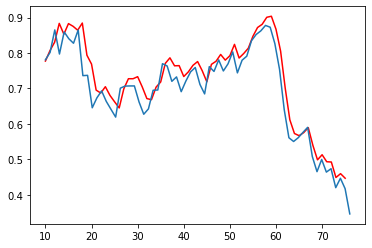

In [25]:
#print(X_test)
prediction = model.predict(X_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color='red')
#plt.plot(testPredictPlot)
#plt.legend(['Actual','Train','Test'])
x=np.linspace(look_back,len(prediction)+look_back,len(y_test))
plt.plot(x,y_test)
plt.show()